In [5]:
#Block 1
#import from drive
from google.colab import drive
drive.mount('/content/drive')

#importing libraries
from PIL import Image
import os
import torch
import torchvision
import cv2
import argparse
import numpy as np
import random
import matplotlib.pyplot as plt
from torchvision.transforms import transforms as transforms

Mounted at /content/drive


In [6]:
#Block 2
# initializing the model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True,
                                                           progress=True, 
                                                           num_classes=91)
# set up computation device & load model into the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device).eval() #eval mode

# using transform to convert the image to tensor
transform = transforms.Compose([transforms.ToTensor()])


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

In [7]:
# Block 3
COLORS = np.random.uniform(0, 255, size=(1000, 3))

#getting masks
def get_outputs(outputs):
    scores = list(outputs[0]['scores'].detach().cpu().numpy())
    max_value = max(scores)
    thresholded_preds_inidices = scores.index(max_value) 

    # one mask picked and the object masks that are below the threshold are discarded
    masks = (outputs[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    masks = masks[:1]

    #getting bounding boxes (x1, y1), (x2, y2) format
    boxes = [[(int(i[0]), int(i[1])), (int(i[2]), int(i[3]))] for i in outputs[0]['boxes'].detach().cpu()]
    # discard bounding boxes below threshold value
    boxes = boxes[:1]
    return masks, boxes

def draw_segmentation_map(image, masks, boxes):
    alpha = 1 
    beta = 0.6 #makes segmentation map more transparent
    gamma = 0 #scalar added to each sum
    for i in range(len(masks)):
        red_map = np.zeros_like(masks[i]).astype(np.uint8)
        green_map = np.zeros_like(masks[i]).astype(np.uint8)
        blue_map = np.zeros_like(masks[i]).astype(np.uint8)
        #applies random mask color to every object
        color = COLORS[random.randrange(0, len(COLORS))] 
        red_map[masks[i] == 1], green_map[masks[i] == 1], blue_map[masks[i] == 1]  = color
        
        #combines all masks into a one image
        segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
        #convert the original PIL image into NumPy format
        image = np.array(image)
        #apply mask on the image
        cv2.addWeighted(image, alpha, segmentation_map, beta, gamma, image)
        
        #draws the bounding box with the corresponding color around the object
        cv2.rectangle(image, boxes[i][0], boxes[i][1], color=color, thickness=5)
    
    return image


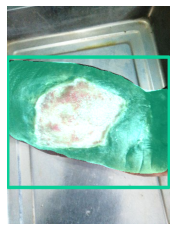

In [8]:
#Block 4
#name of image
images = 'CD00000017_20200810073431_0002_20201102082700_20201102_082703.jpg' 
folder = images[0:10]
image_path = '/content/drive/MyDrive/Skin_Disease/' + images 

#open image & convert to RGB
image = Image.open(image_path).convert('RGB')

# copy original image for OpenCV functions and apply masks
orig_image = image.copy()

# transforming the image
image = transform(image)

# adding a batch dimension
image = image.unsqueeze(0).to(device)

# forward pass of the image through the model
with torch.no_grad():
    outputs = model(image)

# get all the scores
scores = list(outputs[0]['scores'].detach().cpu().numpy())

masks, boxes = get_outputs(outputs)
result = draw_segmentation_map(orig_image, masks, boxes)
plt.axis('off')
plt.imshow(result) 

In [28]:
import pickle


images = 'CD00000017_20200810073431_0002_20201102082700_20201102_082703.pkl' 
folder = images[0:10]
image_path = '/content/drive/MyDrive/Skin_Disease/BU/' + images + ''

with open(image_path, 'rb') as file:
    [masks, boxes] = pickle.load(file)
with open(image_path, 'rb') as file:
    data = pickle.load(file)
print(boxes)


tl = boxes[0][0]
print(tl)

br = boxes[0][1]
print(br)

tr = (boxes[0][1][0],boxes[0][0][1])
print(tr)

bl =(boxes[0][0][0], boxes[0][1][1])
print(bl)

#img = cv2.imread(img_path)
x1 = boxes[0][0][0]
print(x1)
x2= boxes[0][1][0]
print(x2)
y1= boxes[0][0][1]
print(y1)
y2= boxes[0][1][1]
print(y2)


# Crop the data according to your needs
crop= data[boxes[0]]
# Save the cropped data to a new .pkl file
with open("cropped_file.pkl", "wb") as f:
    pickle.dump(crop, f)
    
plt.imshow(crop, cmpa="gray")
plt.show()

[[(1, 105), (335, 374)]]
(1, 105)
(335, 374)
(335, 105)
(1, 374)
1
335
105
374


AttributeError: ignored